# Autoencoder


### Mechanism:
- take an input image
- encode it to get a lower dimensional embedding of the image
- decode the embedding 
- reconstruct the original image as good as possible

Use case: Video compression

For encoding or decoding we can use a simple feed forward neural network

or while dealing with images we usually use convolutional neural networks which perform better

These models are called as generative models

As we are trying to generate the images using the encodings

### Loss function
MSE (Mean Squared Error) which calculates the difference between the intensity values, sums over all the pixels and then calculates the mean value

The operation that is being performed during the encoding part is to be inversely performed in the decoding part.

In case of performing convolution, the inverse is nothing but a transpose of that convolution

'''
 nn.ConvTranspose2d
'''



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])    

mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=64,
                                         shuffle=True)

How does the dataloader work? 

https://www.youtube.com/watch?v=PXOzkkB5eH0



In [3]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


## simple feedforward network with linear layers and a few hidden layers


In [4]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        # N(batchsize), 784(28*28)(no of images in the dataset)
        # we will try to reduce the size with a few linear layers
        # using a sequential model
        
        super().__init__()  # do not forget this
        self.encoder = nn.Sequential(
                    nn.Linear(28*28, 128),  # N, 784 -> N, 128 (trying out different output sizes)
                    nn.ReLU(),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 12),
                    nn.ReLU(),
                    nn.Linear(12, 3)  # -> N, 3
                )
        # repeating the same things in the decoder in the opposite way
        self.decoder = nn.Sequential(
                    nn.Linear(3, 12),  
                    nn.ReLU(),
                    nn.Linear(12, 64),
                    nn.ReLU(),
                    nn.Linear(64, 128),
                    nn.ReLU(),
                    nn.Linear(128, 28*28),  # -> N, 3
                    # we need an activation function here unlike the encoder
                    # because we see the values need to be in the range 0-1
                    nn.Sigmoid()
                )
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Note: If the input images are in the range [-1, 1], then we can simply apply the nn.Tanh function
# this can be done if we apply normalization
# For this you can uncomment the portion in the 2nd code block and then the input range will change from 0-1 to -1.0-1.0

How to create a model, define its loss and optimizer?

https://www.youtube.com/watch?v=VVDHU_TWwUg

In [5]:
model = Autoencoder_Linear()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)

In [10]:
num_epochs = 50
outputs = []

#iterating through the epochs
for epoch in range(num_epochs):
    #iterating through the data loader
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28)  # because the images are in the shape 28*28
        recon = model(img)  # then we call the model and reconstruct the image
        loss = criterion(recon, img)  # calling the criterion over the reconstructed image and the original image
        
        optimizer.zero_grad()  # always zero the gradients
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))
    

Epoch:1, Loss:0.0307
Epoch:2, Loss:0.0344
Epoch:3, Loss:0.0343
Epoch:4, Loss:0.0328
Epoch:5, Loss:0.0360
Epoch:6, Loss:0.0351
Epoch:7, Loss:0.0328
Epoch:8, Loss:0.0352
Epoch:9, Loss:0.0362
Epoch:10, Loss:0.0339
Epoch:11, Loss:0.0299
Epoch:12, Loss:0.0367
Epoch:13, Loss:0.0309
Epoch:14, Loss:0.0352
Epoch:15, Loss:0.0308
Epoch:16, Loss:0.0353
Epoch:17, Loss:0.0316
Epoch:18, Loss:0.0361
Epoch:19, Loss:0.0329
Epoch:20, Loss:0.0347
Epoch:21, Loss:0.0353
Epoch:22, Loss:0.0319
Epoch:23, Loss:0.0336
Epoch:24, Loss:0.0308
Epoch:25, Loss:0.0355
Epoch:26, Loss:0.0313
Epoch:27, Loss:0.0321
Epoch:28, Loss:0.0312
Epoch:29, Loss:0.0275
Epoch:30, Loss:0.0297
Epoch:31, Loss:0.0295
Epoch:32, Loss:0.0359
Epoch:33, Loss:0.0318
Epoch:34, Loss:0.0313
Epoch:35, Loss:0.0362
Epoch:36, Loss:0.0319
Epoch:37, Loss:0.0329
Epoch:38, Loss:0.0327
Epoch:39, Loss:0.0262
Epoch:40, Loss:0.0313
Epoch:41, Loss:0.0366
Epoch:42, Loss:0.0313
Epoch:43, Loss:0.0287
Epoch:44, Loss:0.0325
Epoch:45, Loss:0.0357
Epoch:46, Loss:0.03

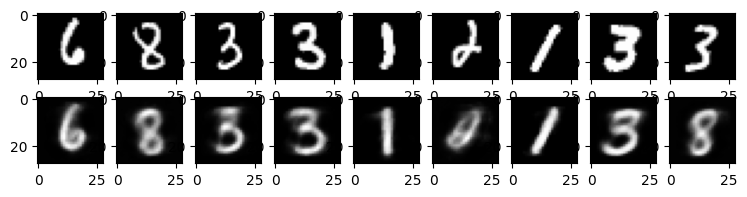

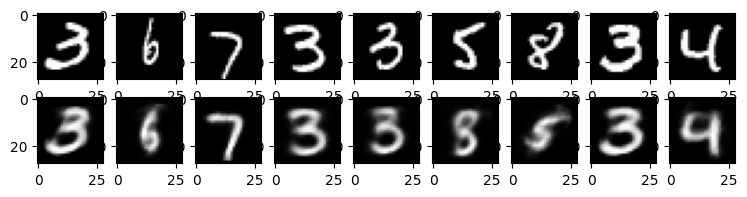

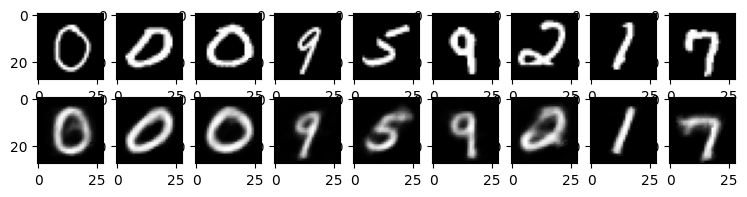

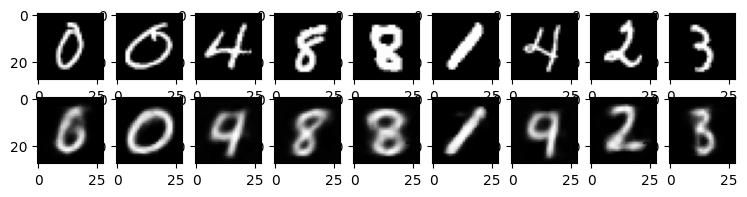

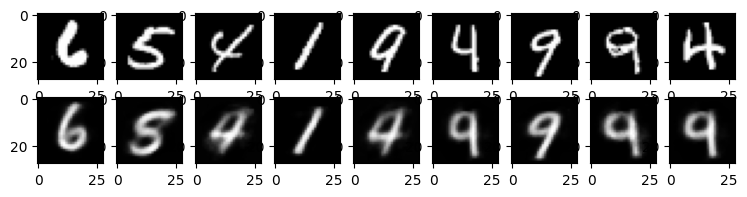

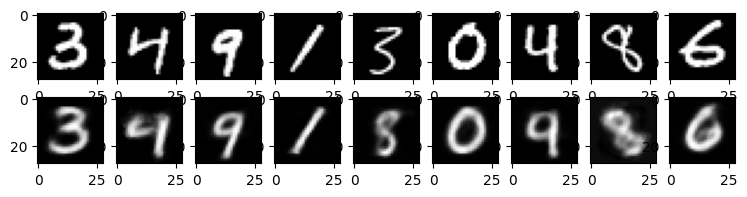

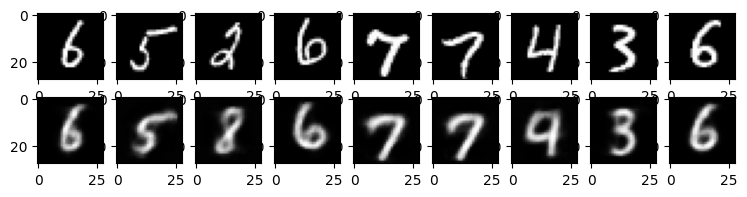

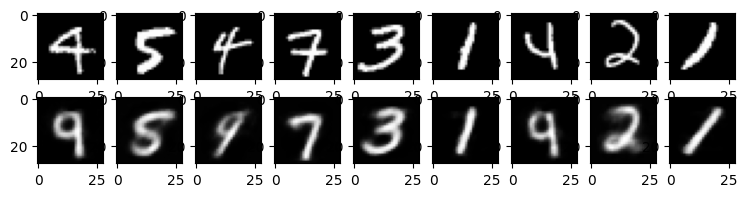

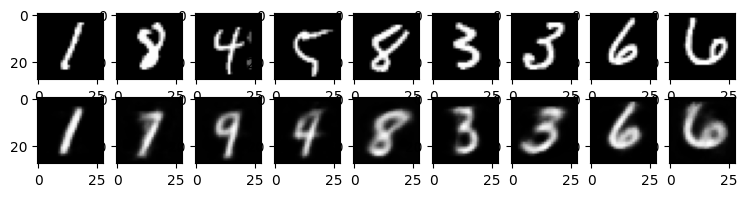

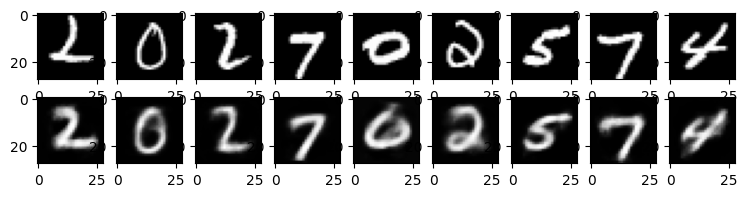

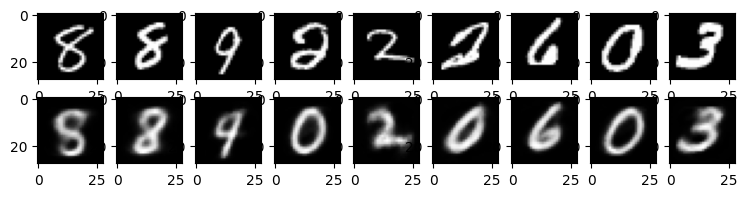

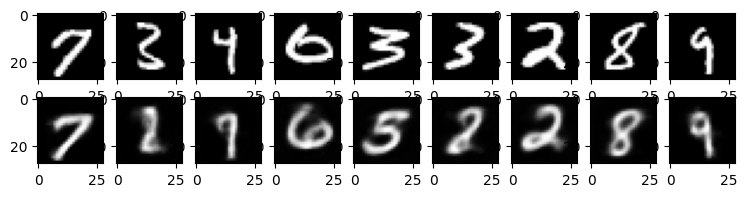

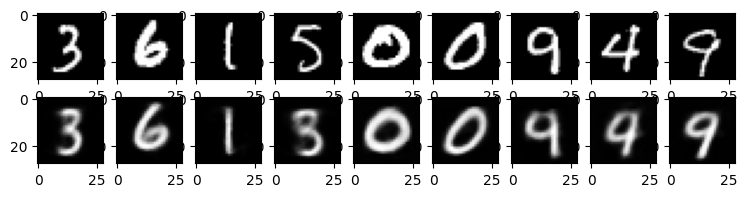

In [11]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()  # as outputs is a torch.tensor, for conv it to numpy we first have to detach it
    recon = outputs[k][2].detach().numpy()  # we convert to numpy usually for plotting purpose
    
    for i, item in enumerate(imgs):   # plotting the first 9 images 
        if i>=9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)  # previously we went from 28, 28 -> 28*28, so now we convert back 
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i>=9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28, 28)
        # item:1, 28, 28
        plt.imshow(item[0])

## creating a CNN autoencoder to improve performance

In [17]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        # here we let the input be 
        # N, 1, 28, 28
        # therefore our first input size is 1
        super().__init__()  # do not forget this
        self.encoder = nn.Sequential(
            # instead of linear layers we can now have conv 2d layers 
            # -> nn.conv2d(input_channels, output_channels, kernel_size, stride, padding)
            
            # it is very important to have the correct shapes and the correct number of input and ouput channels
            # watch the tutorial video given in the next block for reference
                    nn.Conv2d(1, 16, 3, stride=2, padding=1),  # N, 16, 14, 14   # reducing the size of the image by 50%
                    nn.ReLU(),
                    nn.Conv2d(16, 32, 3, stride=2, padding=1),   #N, 32, 7, 7
                    nn.ReLU(),
                    nn.Conv2d(32, 64, 7)   #N, 64, 1, 1 -> less parameters than the input
                    # this means that only one pixel withj 64 channels
                    # we increase the channels while reducing the size of the image
                )
        
        #N, 64, 1, 1 -> input for the decoder
        # repeating the same things in the decoder in the opposite way
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(64, 32, 7),  #N, 32, 7, 7
                    nn.ReLU(),
                    nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # should've been N, 16, 13, 13 but is N, 16, 14, 14 because of the ouyput padding
                    nn.ReLU(),
                    nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   #N, 1, 27, 27 -> N, 1, 28, 28
                    # we need an activation function here unlike the encoder
                    # because we see the values need to be in the range 0-1
                    nn.Sigmoid()
                )
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
# a lot of times in conv nn, for reducing the size of the input, we use 
# nn.MaxPool2d in the encoder, and
# nn.MaxUnpool2d in the decoder

# but we can achieve the similar kind of size reduction by just using convolutions

How do the convolutions work?

https://www.youtube.com/watch?v=pDdP0TFzsoQ

In [18]:
model = Autoencoder_conv()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)

In [20]:
num_epochs = 10
outputs = []

#iterating through the epochs
for epoch in range(num_epochs):
    #iterating through the data loader
    for (img, _) in data_loader:
# we don't need this anymore        img = img.reshape(-1, 28*28)  # because the images are in the shape 28*28
        recon = model(img)  # then we call the model and reconstruct the image
        loss = criterion(recon, img)  # calling the criterion over the reconstructed image and the original image
        
        optimizer.zero_grad()  # always zero the gradients
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0053
Epoch:2, Loss:0.0042
Epoch:3, Loss:0.0035
Epoch:4, Loss:0.0036
Epoch:5, Loss:0.0037
Epoch:6, Loss:0.0029
Epoch:7, Loss:0.0030
Epoch:8, Loss:0.0027
Epoch:9, Loss:0.0028
Epoch:10, Loss:0.0028


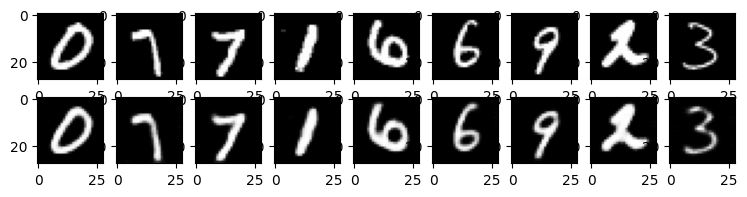

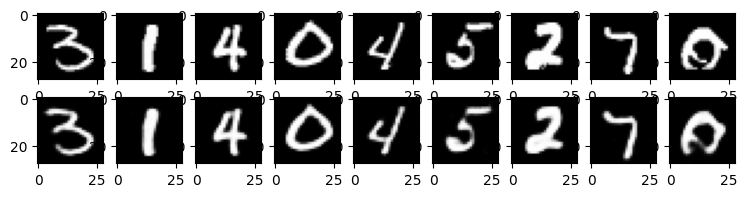

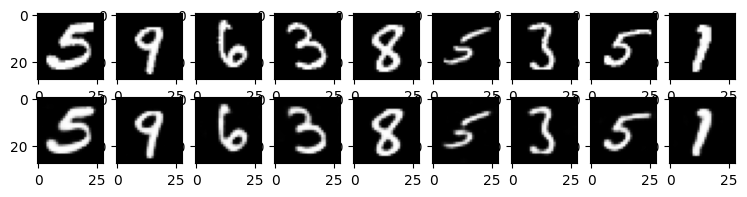

In [21]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()  # as outputs is a torch.tensor, for conv it to numpy we first have to detach it
    recon = outputs[k][2].detach().numpy()  # we convert to numpy usually for plotting purpose
    
    for i, item in enumerate(imgs):   # plotting the first 9 images 
        if i>=9: break
        plt.subplot(2, 9, i+1)
#  we don't need this anymore        item = item.reshape(-1, 28, 28)  # previously we went from 28, 28 -> 28*28, so now we convert back 
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i>=9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
#         item = item.reshape(-1, 28, 28)
        # item:1, 28, 28
        plt.imshow(item[0])

As we see the reconstruction quality has greatly improved within 10 epochs